In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2003 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_03(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata03 = pd.read_csv("perlist03_h.csv")
    f = perdata03['f']
    per = perdata03['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata03)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m03=Minuit(twi_minus_loglikelihood_03,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=1,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-5,0), limit_log_f_b=(-15,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,10),
         errordef=1)

m03.migrad()

pprint(m03.fval)

FCN = 10181.895957184688 
 TOTAL NCALL = 203 
 NCALLS = 203 
 
 
 EDM = 3.6516384685965324e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.94539e-09,0.000150156,,,-5,0,No
1,log_f_b,-2.39567,6.54251,,,-15,-2,No
2,alpha_H,1,0.297677,,,1,5,No
3,poisson,9.99998,0.0341234,,,0,10,No


10181.895957184688


In [4]:
perdata03 = pd.read_csv("perlist03_h.csv")
f_03 = perdata03['f']
per_03 = perdata03['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m03.values[0],m03.values[1],m03.values[2],m03.values[3]

model_03 = []
R_obs_03 = []
T_SSE_obs_03 = 0
f_length_03 = len(f_03)
for i in range(f_length_03):
    model_03.append(((f_03[i]**(-alpha_L))/(1+(f_03[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_03.append(2*per_03[i]/model_03[i])
    T_SSE_obs_03 += (((per_03[i]-model_03[i])/model_03[i])**2)
    
# 两个统计量
T_R_obs_03 = max(R_obs_03)
print ("T_R =", T_R_obs_03)
print ("T_SSE =", T_SSE_obs_03)

T_R = 7.44188271067751
T_SSE = 435.9613464785008


In [5]:
# 5000条光变曲线

df = 0.01/f_length_03
N = 2*f_length_03
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_03]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_03):
        R_simu.append(2*per_simu[i]/model_03[i])
        T_SSE_simu += (((per_simu[i]-model_03[i])/model_03[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_03:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_03:
        n_TSSE += 1

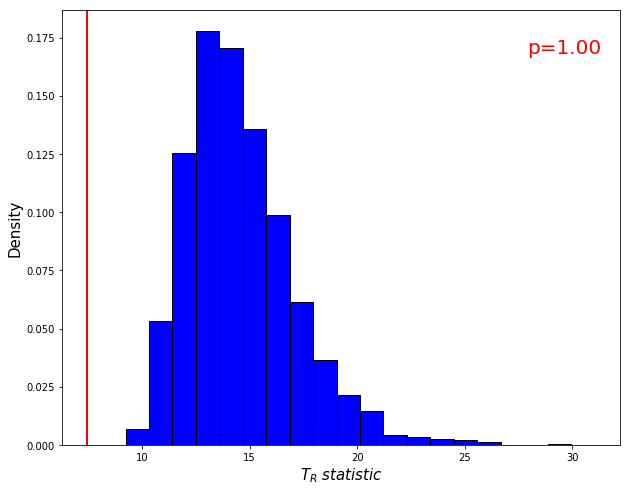

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_03, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

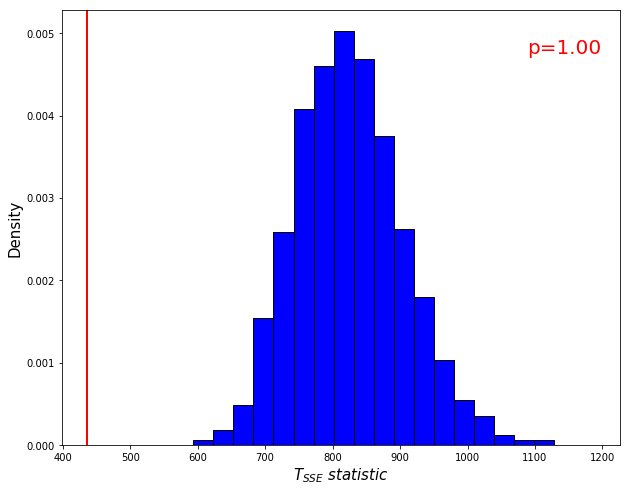

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_03, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2014(1) 统计分析

In [8]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_141(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata141 = pd.read_csv("perlist141_h.csv")
    f = perdata141['f']
    per = perdata141['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata141)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
m141=Minuit(twi_minus_loglikelihood_141,log_A=-1,log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=150,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-2,0), limit_log_f_b=(-7,0),limit_alpha_H=(1.0,5.0),limit_poisson=(100,200),
         errordef=1)

m141.migrad()

pprint(m141.fval)

FCN = 5031.097526035591 
 TOTAL NCALL = 186 
 NCALLS = 186 
 
 
 EDM = 1.882187430133519e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.73385,0.201618,,,-2,0,No
1,log_f_b,-3.49115,0.257955,,,-7,0,No
2,alpha_H,4.99999,3.88905,,,1,5,No
3,poisson,100,0.120452,,,100,200,No


5031.097526035591


In [10]:
perdata141 = pd.read_csv("perlist141_h.csv")
f_141 = perdata141['f']
per_141 = perdata141['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m141.values[0],m141.values[1],m141.values[2],m141.values[3]

model_141 = []
R_obs_141 = []
T_SSE_obs_141 = 0
f_length_141 = len(f_141)
for i in range(f_length_141):
    model_141.append(((f_141[i]**(-alpha_L))/(1+(f_141[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_141.append(2*per_141[i]/model_141[i])
    T_SSE_obs_141 += (((per_141[i]-model_141[i])/model_141[i])**2)
    
# 两个统计量
T_R_obs_141 = max(R_obs_141)
print ("T_R =", T_R_obs_141)
print ("T_SSE =", T_SSE_obs_141)

T_R = 7.125550720237256
T_SSE = 399.32046792077585


In [11]:
# 5000条光变曲线

df = 0.01/f_length_141
N = 2*f_length_141
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_141]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_141):
        R_simu.append(2*per_simu[i]/model_141[i])
        T_SSE_simu += (((per_simu[i]-model_141[i])/model_141[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_141:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_141:
        n_TSSE += 1

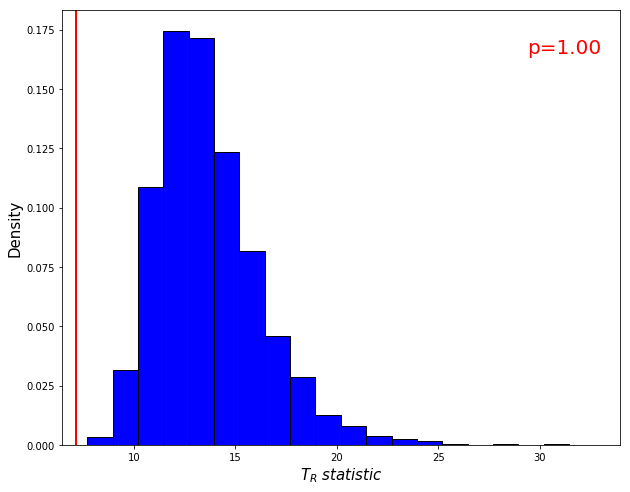

In [12]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_141, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

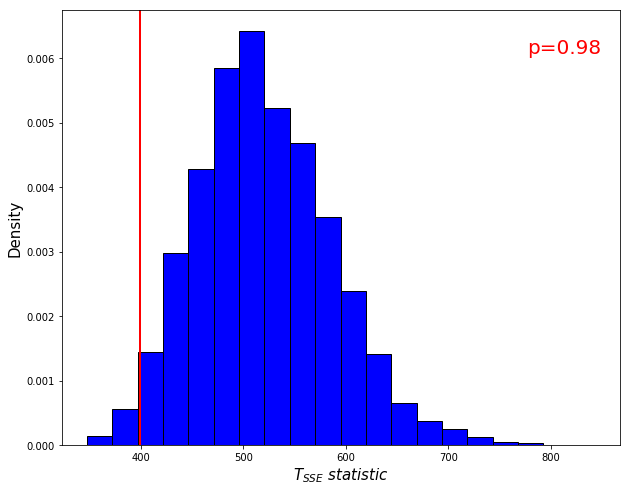

In [13]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_141, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2019 统计分析

In [14]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_19(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata19 = pd.read_csv("perlist19_h.csv")
    f = perdata19['f']
    per = perdata19['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata19)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [ ]:
m19=Minuit(twi_minus_loglikelihood_19,log_A=-1,log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-5,0), limit_log_f_b=(-10,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,10),
         errordef=1)

m19.migrad()

pprint(m19.fval)

In [ ]:
perdata19 = pd.read_csv("perlist19_h.csv")
f_19 = perdata19['f']
per_19 = perdata19['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m19.values[0],m19.values[1],m19.values[2],m19.values[3]

model_19 = []
R_obs_19 = []
T_SSE_obs_19 = 0
f_length_19 = len(f_19)
for i in range(f_length_19):
    model_19.append(((f_19[i]**(-alpha_L))/(1+(f_19[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_19.append(2*per_19[i]/model_19[i])
    T_SSE_obs_19 += (((per_19[i]-model_19[i])/model_19[i])**2)
    
# 两个统计量
T_R_obs_19 = max(R_obs_19)
print ("T_R =", T_R_obs_19)
print ("T_SSE =", T_SSE_obs_19)

In [ ]:
# 5000条光变曲线

df = 0.01/f_length_19
N = 2*f_length_19
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_19]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_19):
        R_simu.append(2*per_simu[i]/model_19[i])
        T_SSE_simu += (((per_simu[i]-model_19[i])/model_19[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_19:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_19:
        n_TSSE += 1

In [ ]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_19, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

In [ ]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_19, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 综合结果

In [14]:
data03 = pd.read_csv("energy_ngc4395_03.csv")  
x03 = data03['x']
y03 = data03['y']
xerr03 = data03['xerr']
yerr03 = data03['yerr']

data141 = pd.read_csv("energy_ngc4395_141.csv")  
x141 = data141['x']
y141 = data141['y']
xerr141 = data141['xerr']
yerr141 = data141['yerr']

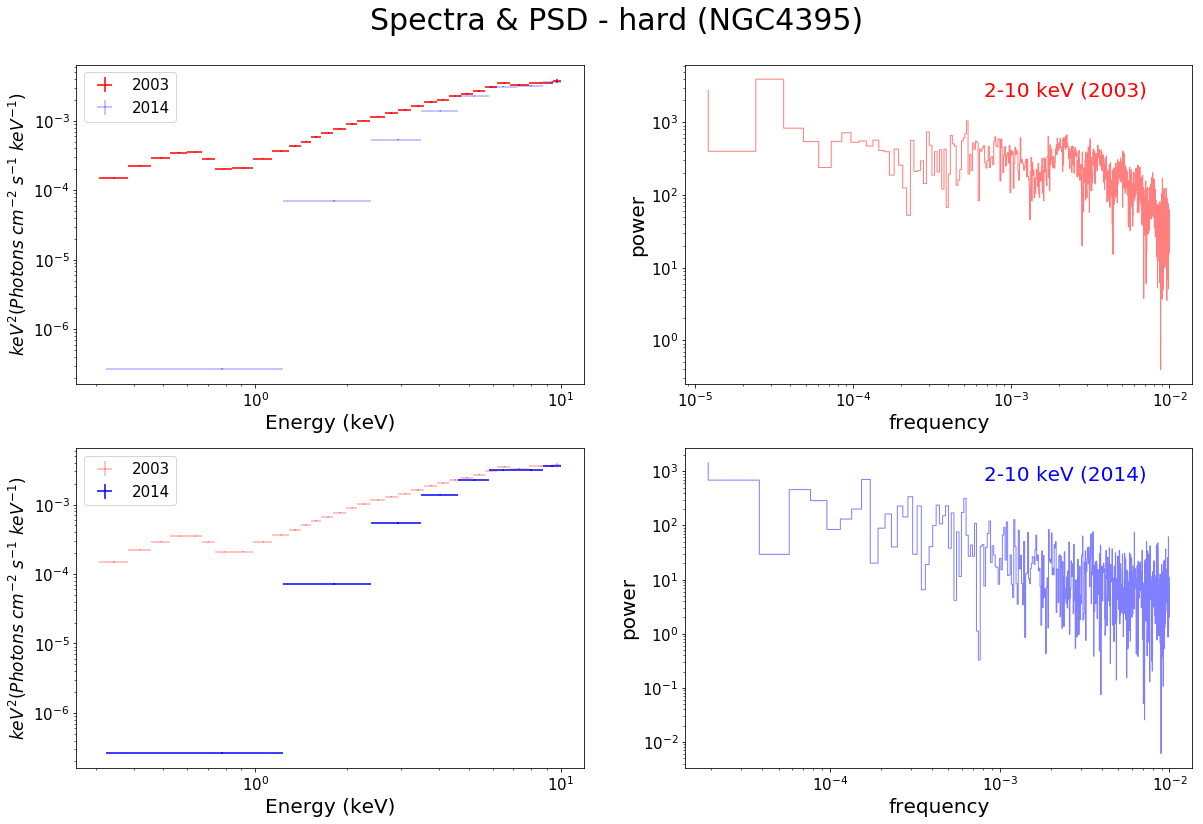

In [17]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
#ax5 = plt.subplot(325)
#ax6 = plt.subplot(326)


ax1.loglog()
ax1.errorbar(x03, y03, yerr=yerr03, xerr=xerr03, fmt=',r', label='2003')
ax1.errorbar(x141, y141, yerr=yerr141, xerr=xerr141, fmt=',b', alpha=0.3, label='2014')
#ax1.errorbar(x19, y19, yerr=yerr19, xerr=xerr19, fmt=',g', alpha=0.3, label='2019')
ax1.set_xlabel("Energy (keV)",fontsize=20)
ax1.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)

ax3.loglog()
ax3.errorbar(x03, y03, yerr=yerr03, xerr=xerr03, fmt=',r', alpha=0.3, label='2003')
ax3.errorbar(x141, y141, yerr=yerr141, xerr=xerr141, fmt=',b', label='2014')
#ax3.errorbar(x19, y19, yerr=yerr19, xerr=xerr19, fmt=',g', alpha=0.3, label='2019')
ax3.set_xlabel("Energy (keV)",fontsize=20)
ax3.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax3.legend(fontsize=15)
ax3.tick_params(labelsize=15)

'''
ax5.loglog()
ax5.errorbar(x03, y03, yerr=yerr03, xerr=xerr03, fmt=',r', alpha=0.3, label='2003')
ax5.errorbar(x141, y141, yerr=yerr141, xerr=xerr141, fmt=',b', alpha=0.3, label='2014')
ax5.errorbar(x19, y19, yerr=yerr19, xerr=xerr19, fmt=',g', label='2019')
ax5.set_xlabel("Energy (keV)",fontsize=20)
ax5.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax5.legend(fontsize=15)
ax5.tick_params(labelsize=15)
'''

ax2.loglog()
ax2.step(f_03, per_03, color="r", alpha=0.5, linewidth=1)
#ax2.plot(f_03, model_03, color="r", linewidth=1)
ax2.set_xlabel("frequency",fontsize=20)
ax2.set_ylabel("power",fontsize=20)
ax2.text(0.75,0.9,"2-10 keV (2003)",color='r',ha='center',transform=ax2.transAxes,fontsize=20)
ax2.tick_params(labelsize=15)

ax4.loglog()
ax4.step(f_141, per_141, color="b", alpha=0.5, linewidth=1)
#ax4.plot(f_141, model_141, color="b", linewidth=1)
ax4.set_xlabel("frequency",fontsize=20)
ax4.set_ylabel("power",fontsize=20)
ax4.text(0.75,-0.3,"2-10 keV (2014)",color='b',ha='center',transform=ax2.transAxes,fontsize=20)
ax4.tick_params(labelsize=15)

'''
ax6.loglog()
ax6.step(f_19, per_19, color="k", alpha=0.5, linewidth=1)
ax6.plot(f_19, model_19, color="g", linewidth=1)
ax6.set_xlabel("frequency",fontsize=20)
ax6.set_ylabel("power",fontsize=20)
ax6.text(0.75,-1.5,"2-10 keV (2019)",color='g',ha='center',transform=ax2.transAxes,fontsize=20)
ax6.tick_params(labelsize=15)
'''

plt.suptitle("Spectra & PSD - hard (NGC4395)", x=0.5, y=0.92, fontsize=30)
plt.show()

## 2003 MCMC

In [10]:
# 均匀先验

def lnprior_03(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -8 < log_A < 25 and -15 < log_f_b < -2 and 1.0 < alpha_H < 20.0 and 0.0 < poisson < 5.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_03(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_03(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_03(log_A,log_f_b,alpha_H,poisson))

In [11]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m03.values[0],m03.values[1],m03.values[2],m03.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_03)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1116.4 seconds


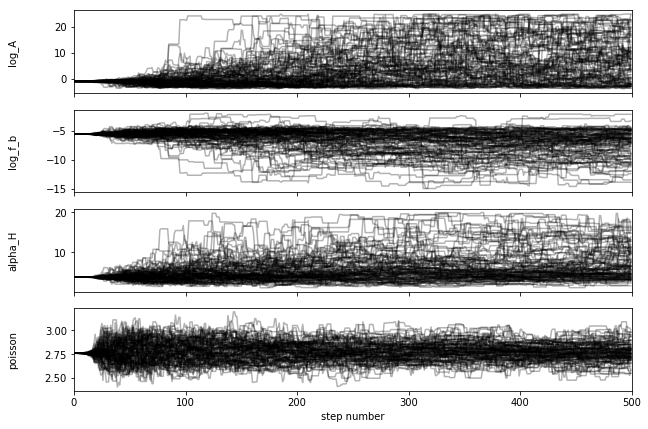

In [12]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [13]:
print ("Parameters (2001)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2001)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

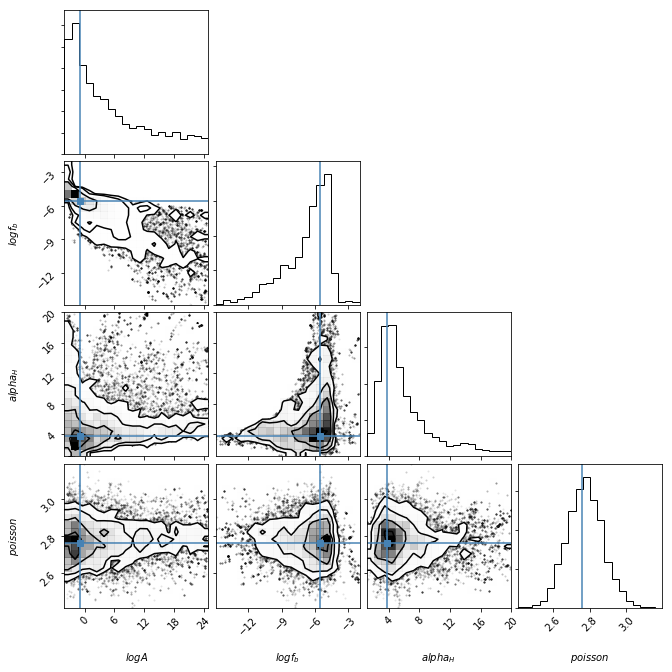

In [14]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m03.values[0], m03.values[1], m03.values[2], m03.values[3]])

## 2014(1) MCMC

In [15]:
# 均匀先验

def lnprior_141(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -5 < log_A < 10 and -20 < log_f_b < -2 and 1.0 < alpha_H < 10.0 and 0.0 < poisson < 3.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_141(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_141(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_141(log_A,log_f_b,alpha_H,poisson))

In [16]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m141.values[0],m141.values[1],m141.values[2],m141.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_141)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 753.3 seconds


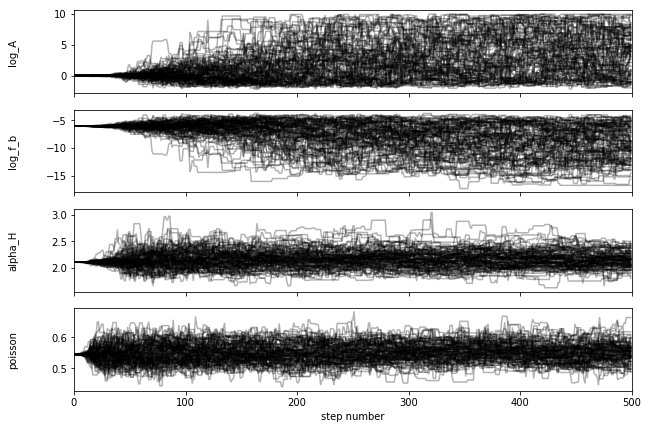

In [17]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [18]:
print ("Parameters (2006)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2006)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

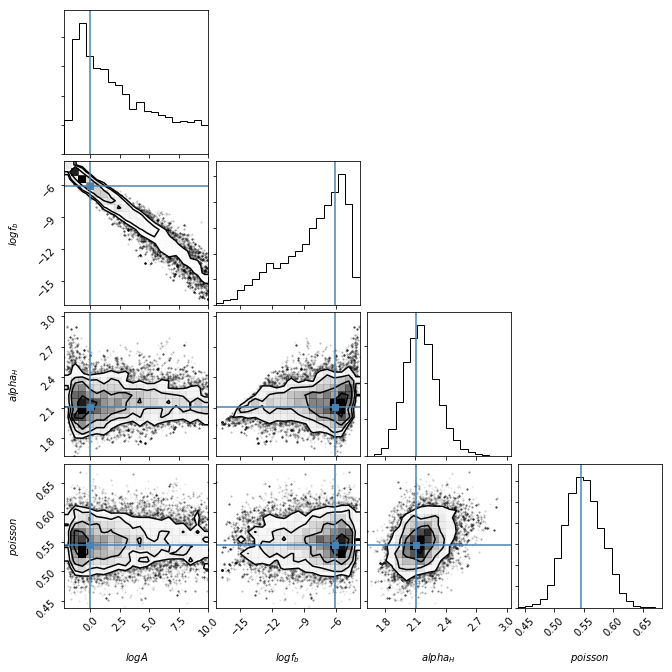

In [19]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m141.values[0], m141.values[1], m141.values[2], m141.values[3]])

## 2019 MCMC